### 1b. Load training and test set

In [26]:
import numpy as np
import pandas as pd
from imageio import imread
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import scipy as sp

(540, 2500) (540,)


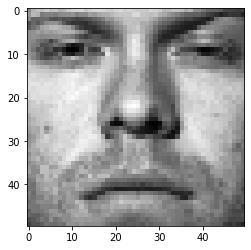

In [27]:
def read_img(path):
    yTrain, XTrain = [], []

    for line in open(path):
        im = imread(line.strip().split()[0])
        XTrain.append(im.reshape(2500,))
        yTrain.append(line.strip().split()[1])

    return np.array(XTrain, dtype=float), np.array(yTrain, dtype=int)

def plot_img(n, X):
    plt.imshow(X[n, :].reshape(50,50), cmap = cm.Greys_r)
    plt.show()

XTrain, yTrain = read_img('./faces/train.txt')
print(XTrain.shape, yTrain.shape)

plot_img(10, XTrain)

(100, 2500) (100,)


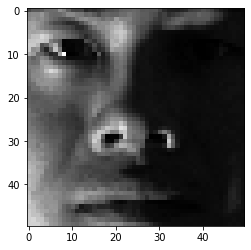

In [28]:
XTest, yTest = read_img('./faces/test.txt')
print(XTest.shape, yTest.shape)
plot_img(10, XTest)

### 1c. Average face

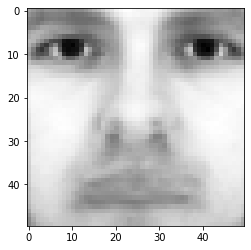

In [29]:
avgFace = np.mean(XTrain, axis=0)
plt.imshow(avgFace.reshape(50,50), cmap = cm.Greys_r)
plt.show()

### 1d. Mean substraction

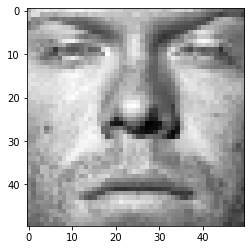

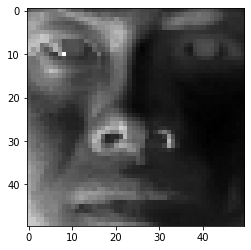

In [30]:
demeaned_XTrain = XTrain - avgFace
demeaned_XTest = XTest - avgFace
plot_img(10, demeaned_XTrain)
plot_img(10, demeaned_XTest)

### 1e. Eigenface

(2500, 2500)
(540, 540)


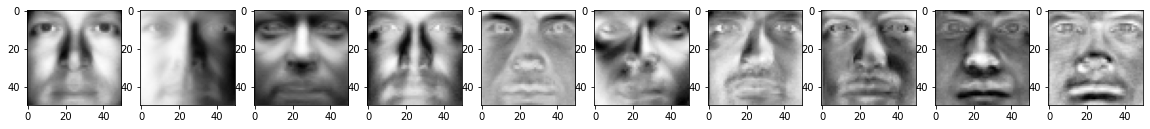

In [66]:
U, S, V = np.linalg.svd(demeaned_XTrain)
print(np.shape(V))
print(np.shape(U))

fig, axs = plt.subplots(1,10, figsize=(20,20))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(V[i, :].reshape(50,50), cmap = cm.Greys_r)

### 1f. Low-rank approximation

In [122]:
sigma = np.diag(S)
norms = []
ranks = np.arange(0,200,1)

In [123]:
for rank in ranks:
	r = rank
	approx_XTrain = U[:,:r].dot(sigma[:r,:r]).dot(V[:r,:])
	approx_error = demeaned_XTrain - approx_XTrain
	norm = np.linalg.norm(approx_error, ord='fro')
	norms.append(norm)

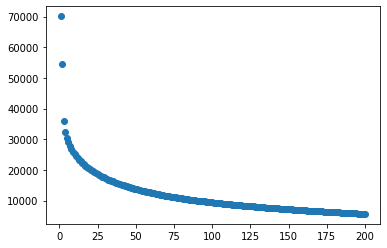

In [124]:
plt.scatter(ranks+1,norms)
plt.savefig('lr_error')

### 1g. Eigenface feature

In [35]:
def generate_feature_matrix(X, V, r):
    return np.dot(X,np.transpose(V[:r,:]))

### 1h. Face recognition

In [36]:
FTrain = generate_feature_matrix(XTrain, V, 10)
FTest = generate_feature_matrix(XTest, V, 10)

logReg = LogisticRegressionCV(multi_class="ovr", n_jobs=-1)

logReg.fit(FTrain, yTrain)
yPredict = logReg.predict(FTest)

print("Accuracy: %s"%accuracy_score(yTest, yPredict))

Accuracy: 0.82


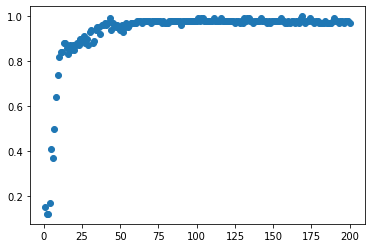

In [37]:
x = list(range(1,201))
y = []
for r in x:
    FTrain = generate_feature_matrix(XTrain, V, r)
    FTest = generate_feature_matrix(XTest, V, r)

    logReg = LogisticRegressionCV(multi_class="ovr", n_jobs=-1)

    logReg.fit(FTrain, yTrain)
    yPredict = logReg.predict(FTest)

    y.append(accuracy_score(yTest, yPredict))
    
plt.scatter(x,y)

In [38]:
M = np.array([[1,0,3],[3,7,2],[2,-2,8],[0,-1,1],[5,8,7]])
mtm = M.T.dot(M)
print(mtm)

[[ 39  57  60]
 [ 57 118  53]
 [ 60  53 127]]


In [39]:
mmt = M.dot(M.T)
print(mmt)

[[ 10   9  26   3  26]
 [  9  62   8  -5  85]
 [ 26   8  72  10  50]
 [  3  -5  10   2  -1]
 [ 26  85  50  -1 138]]


In [40]:
w1, v1 = np.linalg.eig(mtm)
w1
v1

array([[ 0.42615127,  0.90453403, -0.01460404],
       [ 0.61500884, -0.30151134, -0.72859799],
       [ 0.66344497, -0.30151134,  0.68478587]])

In [41]:
w2, v2 = np.linalg.eig(mmt)
w2

array([ 2.14670489e+02, -5.99520433e-15,  6.93295108e+01,  1.23720729e-14,
       -7.24621456e-16])

In [43]:
print(v1)
# matrixTeX(v2)

[[ 0.42615127  0.90453403 -0.01460404]
 [ 0.61500884 -0.30151134 -0.72859799]
 [ 0.66344497 -0.30151134  0.68478587]]


In [44]:
print(v2)

[[-0.16492942 -0.95539856  0.24497323 -0.06464508 -0.10671808]
 [-0.47164732 -0.03481209 -0.45330644  0.75010839 -0.04684757]
 [-0.33647055  0.27076072  0.82943965  0.3284142  -0.17364364]
 [-0.00330585  0.04409532  0.16974659  0.04591676  0.97063121]
 [-0.79820031  0.10366268 -0.13310656 -0.5685017   0.11890961]]


In [45]:
np.sqrt(w1)

array([14.65163776,         nan,  8.32643446])

In [46]:
v1.dot(np.diag(w1)).dot(v1.T)

array([[ 39.,  57.,  60.],
       [ 57., 118.,  53.],
       [ 60.,  53., 127.]])

In [47]:
v2.dot(np.diag(w2)).dot(v2.T)

array([[ 10.,   9.,  26.,   3.,  26.],
       [  9.,  62.,   8.,  -5.,  85.],
       [ 26.,   8.,  72.,  10.,  50.],
       [  3.,  -5.,  10.,   2.,  -1.],
       [ 26.,  85.,  50.,  -1., 138.]])

In [48]:
w1_matrix = np.diag(w1)
w1_matrix[1,1] = 0
w2_matrix = np.diag(w2)
w2_matrix[1,1] = 0

In [49]:
s_mtm = sp.linalg.sqrtm(w1_matrix)
s_mmt = sp.linalg.sqrtm(w2_matrix)
U = v2
V = v1
v2
v1

array([[ 0.42615127,  0.90453403, -0.01460404],
       [ 0.61500884, -0.30151134, -0.72859799],
       [ 0.66344497, -0.30151134,  0.68478587]])

In [50]:
s_mtm = np.delete(np.delete(s_mtm,1,1),1,0)
s_mtm

array([[14.65163776,  0.        ],
       [ 0.        ,  8.32643446]])

In [51]:
U = np.delete(U[:,:3],1,1)
U

array([[-0.16492942,  0.24497323],
       [-0.47164732, -0.45330644],
       [-0.33647055,  0.82943965],
       [-0.00330585,  0.16974659],
       [-0.79820031, -0.13310656]])

In [52]:
V = np.delete(V,1,1)
V

array([[ 0.42615127, -0.01460404],
       [ 0.61500884, -0.72859799],
       [ 0.66344497,  0.68478587]])

In [53]:
print(U.shape)
print(V.shape)
print(s_mtm.shape)

(5, 2)
(3, 2)
(2, 2)


In [54]:
w2

array([ 2.14670489e+02, -5.99520433e-15,  6.93295108e+01,  1.23720729e-14,
       -7.24621456e-16])

In [55]:
M_SVD = U.dot(s_mtm).dot(V.T)

In [56]:
M_SVD[:,0]/-1.05

array([1.00912123, 2.75214881, 2.09687528, 0.03931641, 4.73107485])

In [57]:
Uc, Sc, Vc = np.linalg.svd(M)

In [58]:
print(Uc)
print(U)

[[-0.16492942 -0.24497323  0.94690858  0.02817617 -0.12392196]
 [-0.47164732  0.45330644 -0.06559072  0.10010213 -0.74681959]
 [-0.33647055 -0.82943965 -0.30585475 -0.15523825 -0.28490595]
 [-0.00330585 -0.16974659 -0.0689086   0.98238169  0.03678296]
 [-0.79820031  0.13310656 -0.02768538 -0.00360121  0.58683853]]
[[-0.16492942  0.24497323]
 [-0.47164732 -0.45330644]
 [-0.33647055  0.82943965]
 [-0.00330585  0.16974659]
 [-0.79820031 -0.13310656]]


In [59]:
print(Sc)
print(s_mtm)

[1.46516378e+01 8.32643446e+00 1.68573193e-15]
[[14.65163776  0.        ]
 [ 0.          8.32643446]]


In [60]:
print(Vc)
print(V)


[[-0.42615127 -0.61500884 -0.66344497]
 [ 0.01460404  0.72859799 -0.68478587]
 [-0.90453403  0.30151134  0.30151134]]
[[ 0.42615127 -0.01460404]
 [ 0.61500884 -0.72859799]
 [ 0.66344497  0.68478587]]


In [61]:
vals, vectors = np.linalg.eigh(np.diag([1,1]))

In [62]:
vals
vectors

array([[1., 0.],
       [0., 1.]])

In [63]:
# matrixTeX(mtm)

NameError: name 'matrixTeX' is not defined

In [ ]:
def matrixTeX(a, decimal=0, justifyRight=False, suppress=True, formatString=None):
	"""

	Returns a LaTeX bmatrix or bmatrix* environment

	::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
	: Input   		:
	: a			: numpy array or matrix
	: decimal		: 0 or # of decimal digits
	:			  (default: inherit from numpy array)
	: justifyRight		: should numbers be rightjustifited
	:			  good for -ve and +ve #s in same col
	:			  (default = center justified)
	: suppress		: set small values to zero
	:				  (default = True)
	: formatString 		: example '.3e' or '0.2f' (overrides decimal setting!)
	:				  if matrix full of integers, then automatically detect
	:				  (default = None)
	::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
	:
	:returns		: LaTeX bmatrix or bmatrix* as a string
	:
	::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
	ex1: floats
	y = (np.random.rand(6).reshape(3,2) - 0.5)
	matrixTeX(y)
	matrixTeX(y, decimal=2)
	matrixTeX(y, decimal=0, justifyRight=True, suppress=False, formatString='.3f')

	ex2: (integers)
	y = np.random.randint(0,100, (3,2))
	matrixTeX(y)
	"""

	import numpy as np

	#
	# Check if a is array or matrix
	#
	if len(a.shape) > 2:
		raise ValueError('bmatrix can at most display two dimensions')

	#
	# If decimal, 0 => inherit format, else round up numbers
	#
	if isinstance(decimal, int):
		if decimal > 0:
			a = np.around(a, decimal)
		elif (decimal < 0):
			raise ValueError('decimal should be 0/False or a positive integer')

	#
	# Suppress small values near machine precision?
	#
	if suppress:
		np.set_printoptions(suppress=True)

	#
	# If particular format (int or nonfloat) desired, then specify
	#
	if formatString != None:
		strfmt = '{: ' + formatString + '}'
		np.set_printoptions(formatter={'float': strfmt.format})

	#
	# If Right Justify
	#
	if not justifyRight:
		rv = [r'\begin{bmatrix}']
	else:
		rv = [r'\begin{bmatrix*}[r]']

	#
	# Major Work here
	#
	lines = str(a).replace('[', '').replace(']', '').splitlines()
	rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]

	#
	# Closer, for right justify
	#
	if not justifyRight:
		rv +=  [r'\end{bmatrix}']
	else:
		rv +=  [r'\end{bmatrix*}']

	return '\n'.join(rv)






















